## Random Forest Implementation (reused from previous) on scaled non-reduced dataset

Imports

In [1]:
# Utilities
import pandas as pd
import warnings
import numpy as np
import matplotlib.pyplot as plt

# Models
import optuna
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, accuracy_score, f1_score
from sklearn.metrics import classification_report, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay

C:\Users\movil\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Set random seed for reproductibility

In [2]:
seed = 42

Read clean (scaled data)

In [3]:
df_scaled = pd.read_csv('CleanedData/dataset_preprocessed.csv')

Take sample for (initial) tests

In [4]:
#df_scaled_sample = df_scaled.sample(n=1000, random_state=seed)
df_scaled_sample = df_scaled

Train-Test Split

In [5]:
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(
    df_scaled_sample.drop('averageRating', axis=1), 
    df_scaled_sample['averageRating'], test_size=test_size, 
    random_state=seed
)

Save and print metrics

In [6]:
def calculate_metrics(model_name, y_true, y_pred):
    metrics = {
        'Accuracy': accuracy_score(y_true, y_pred),
        'Weighted F1': f1_score(y_true, y_pred, average='weighted'),
        'Weighted Precision': precision_score(y_true, y_pred, average='weighted', zero_division=0),
        'Weighted Recall': recall_score(y_true, y_pred, average='weighted'),
        'Macro-Averaged Precision': precision_score(y_true, y_pred, average='macro', zero_division=0),
        'Macro-Averaged Recall': recall_score(y_true, y_pred, average='macro'),
        'F1': str(f1_score(y_true, y_pred, average=None)),
        'Precision': str( precision_score(y_true, y_pred, average=None, zero_division=0)),
    }
    
    # Print the metrics
    print(f"Metrics for {model_name}:")
    for metric_name, metric_value in metrics.items():
        try:
            print(f"{metric_name}: {metric_value:.4f}")
        except:
            print(f"{metric_name}: {metric_value}")
    
    # Print the classification report
    print("classification report")
    report = classification_report(y_true, y_pred, target_names=['Class 0', 'Class 1', 'Class 2'], zero_division=0)
    print(report)

    print("Confusion Matrix")
    cm = confusion_matrix(y_true, y_pred)
    cmd = ConfusionMatrixDisplay(confusion_matrix=cm)
    cmd.plot()
    
    plt.title(f'Confusion matrix for model {model_name} (Accuracy:{metrics["Accuracy"]:.4f})')
    plt.show()
    
    # Create df to store metrics
    df_metrics = pd.DataFrame(metrics, index=[model_name])
    
    return df_metrics

In [7]:
model = RandomForestClassifier(n_estimators=100, random_state=seed)
model.fit(X_train, y_train)

predictions = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, predictions))

print("F1 score:", f1_score(y_test, predictions, average=None))

Accuracy: 0.7747188832880961
F1 score: [0.         0.81132075 0.73268293]


## Grid Search CV - 1

In [8]:
param_grid = {
    'n_estimators': [10, 50, 100, 200],  # Number of trees in the forest
    'max_depth': [None, 10, 20, 30],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],  # Minimum number of samples required to be at a leaf node
    'bootstrap': [True, False]  # Method of selecting samples for training each tree
}

model = RandomForestClassifier(random_state=seed)

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2, scoring='accuracy')
grid_search.fit(X_train, y_train)

print("The parameters with the highest score: ", grid_search.best_params_)

Fitting 3 folds for each of 288 candidates, totalling 864 fits
The parameters with the highest score:  {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}


In [9]:
cv_results_df = pd.DataFrame(grid_search.cv_results_)

# Show top 10 parameters for this model
minimalistic_results = cv_results_df[['params', 'mean_test_score']]
sorted_results = minimalistic_results.sort_values(by='mean_test_score', ascending=False)

print(sorted_results.head(10))

                                                params  mean_test_score
151  {'bootstrap': False, 'max_depth': None, 'min_s...         0.789005
262  {'bootstrap': False, 'max_depth': 30, 'min_sam...         0.788325
271  {'bootstrap': False, 'max_depth': 30, 'min_sam...         0.788229
15   {'bootstrap': True, 'max_depth': None, 'min_sa...         0.788035
163  {'bootstrap': False, 'max_depth': None, 'min_s...         0.787938
219  {'bootstrap': False, 'max_depth': 20, 'min_sam...         0.787841
270  {'bootstrap': False, 'max_depth': 30, 'min_sam...         0.787453
162  {'bootstrap': False, 'max_depth': None, 'min_s...         0.787453
263  {'bootstrap': False, 'max_depth': 30, 'min_sam...         0.787259
159  {'bootstrap': False, 'max_depth': None, 'min_s...         0.787259


Metrics for RF-GS-CV1:
Accuracy: 0.7728
Weighted F1: 0.7665
Weighted Precision: 0.7620
Weighted Recall: 0.7728
Macro-Averaged Precision: 0.5139
Macro-Averaged Recall: 0.5160
F1: [0.         0.80647292 0.73664122]
Precision: [0.         0.77969349 0.76209279]
classification report
              precision    recall  f1-score   support

     Class 0       0.00      0.00      0.00        34
     Class 1       0.78      0.84      0.81      1462
     Class 2       0.76      0.71      0.74      1083

    accuracy                           0.77      2579
   macro avg       0.51      0.52      0.51      2579
weighted avg       0.76      0.77      0.77      2579

Confusion Matrix


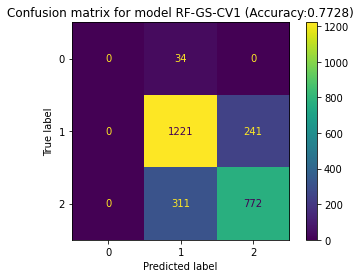

In [10]:
best_model = grid_search.best_estimator_
predictions = best_model.predict(X_test)
_ = calculate_metrics('RF-GS-CV1', y_test, predictions)

In [11]:
# Predicting using other alternatives of fine-tuning from top 10 performances

# Choose a set of parameters from sorted_results
for i in range(10):

  params = sorted_results.iloc[i]['params']
  print("Parameters from place: ", i, " ", params)

  model = RandomForestClassifier(random_state=seed, **params)
  model.fit(X_train, y_train)

  predictions = model.predict(X_test)

  chosen_accuracy = accuracy_score(y_test, predictions)
  print("Accuracy for chosen parameters:", chosen_accuracy)


Parameters from place:  0   {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Accuracy for chosen parameters: 0.7727801473439317
Parameters from place:  1   {'bootstrap': False, 'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
Accuracy for chosen parameters: 0.7712291585886002
Parameters from place:  2   {'bootstrap': False, 'max_depth': 30, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}
Accuracy for chosen parameters: 0.7727801473439317
Parameters from place:  3   {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
Accuracy for chosen parameters: 0.7770453664210935
Parameters from place:  4   {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}
Accuracy for chosen parameters: 0.7751066304769291
Parameters from place:  5   {'bootstrap': False, 'max_depth': 20, 'mi

In [12]:
# Run on training sample

# Choose a set of parameters from sorted_results
for i in range(10):

  params = sorted_results.iloc[i]['params']
  print("Parameters from place: ", i, " ", params)

  model = RandomForestClassifier(random_state=42, **params)
  model.fit(X_train, y_train)

  predictions = model.predict(X_train)

  chosen_accuracy = accuracy_score(y_train, predictions)
  print("Accuracy for chosen parameters:", chosen_accuracy)

Parameters from place:  0   {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Accuracy for chosen parameters: 1.0
Parameters from place:  1   {'bootstrap': False, 'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
Accuracy for chosen parameters: 0.9908852904101619
Parameters from place:  2   {'bootstrap': False, 'max_depth': 30, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}
Accuracy for chosen parameters: 0.993600310287986
Parameters from place:  3   {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
Accuracy for chosen parameters: 0.9584989818675458
Parameters from place:  4   {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}
Accuracy for chosen parameters: 0.9941821002618055
Parameters from place:  5   {'bootstrap': False, 'max_depth': 20, 'min_samples_leaf':

In [13]:
accuracies=[]
max_depths=[]
for i in reversed(range(1,15)):
  model = RandomForestClassifier(random_state=42, max_depth=i)
  model.fit(X_train, y_train)
  predictions = model.predict(X_train)
  accuracy = accuracy_score(y_train, predictions)
  max_depths.append(i)
  accuracies.append(accuracy)
  print("Accuracy for max depth :", i, " ", accuracy)

Accuracy for max depth : 14   0.8927567148259479
Accuracy for max depth : 13   0.8731697857073596
Accuracy for max depth : 12   0.8519344516629497
Accuracy for max depth : 11   0.8327353825269078
Accuracy for max depth : 10   0.8133423833995927
Accuracy for max depth : 9   0.7927858043246389
Accuracy for max depth : 8   0.7785319499660622
Accuracy for max depth : 7   0.7637932706293028
Accuracy for max depth : 6   0.751672646174731
Accuracy for max depth : 5   0.7369339668379715
Accuracy for max depth : 4   0.7254920973528556
Accuracy for max depth : 3   0.7118200329680985
Accuracy for max depth : 2   0.6871909240764085
Accuracy for max depth : 1   0.6513138756908756


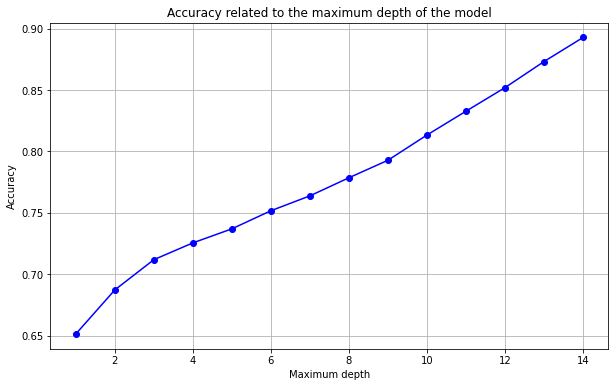

In [14]:
plt.figure(figsize=(10, 6))
plt.plot(max_depths, accuracies, marker='o', linestyle='-', color='b')

plt.title('Accuracy related to the maximum depth of the model')
plt.xlabel('Maximum depth')
plt.ylabel('Accuracy')
plt.grid(True)

plt.show()

In [15]:
best_accuracy = 0
best_report = None
best_predictions = None
y_best_predictions = None
all_reports = []

for i in range(100):
  random_state_fit = np.random.randint(1000)

  test_size = 0.2
  X_train, X_test, y_train, y_test = train_test_split(
    df_scaled_sample.drop('averageRating', axis=1), 
    df_scaled_sample['averageRating'], test_size=test_size, 
    random_state=random_state_fit)
  
  # Best performing parameters
  model = RandomForestClassifier(n_estimators=100, random_state=seed, bootstrap=False, max_depth=20,
                                  min_samples_leaf=1, min_samples_split=2)
  model.fit(X_train, y_train)

  predictions = model.predict(X_test)
  current_accuracy = accuracy_score(y_test, predictions)

  report = classification_report(y_test, predictions, output_dict=True, zero_division=0)
  all_reports.append(report)
  print(current_accuracy)

  if current_accuracy > best_accuracy:
        best_accuracy = current_accuracy
        best_report = report
        best_predictions = predictions
        y_best_predictions = y_test

def average_classification_report(reports):
    metrics = ['precision', 'recall', 'f1-score']
    avg_report = {}
    for metric in metrics:
        avg_report[metric] = sum(r['macro avg'][metric] for r in reports) / len(reports)
    avg_report['accuracy'] = sum(r['accuracy'] for r in reports) / len(reports)
    return avg_report

avg_report = average_classification_report(all_reports)

print("Best Classification Report:")
print(classification_report(y_best_predictions, best_predictions, zero_division=0))
print("Best Accuracy:", best_accuracy)
print()
print("Average Classification Report:")
for metric, score in avg_report.items():
    print(f"{metric}: {score:.4f}")

0.7789841023652578
0.7902287708414114
0.7983714618069019
0.7828615742535867
0.7844125630089182
0.7739433889104304
0.7879022877084141
0.7820860798759209
0.7840248158200853
0.7964327258627375
0.7766576192322606
0.7824738270647538
0.7855758045754169
0.7890655292749128
0.7890655292749128
0.7832493214424195
0.7820860798759209
0.7859635517642497
0.7727801473439317
0.7952694842962389
0.781698332687088
0.768902675455603
0.781698332687088
0.7871267933307483
0.7828615742535867
0.778596355176425
0.7770453664210935
0.7638619620007755
0.7712291585886002
0.7708414113997674
0.7968204730515703
0.801085692128732
0.7851880573865839
0.7983714618069019
0.7836370686312524
0.7782086079875921
0.7782086079875921
0.7747188832880961
0.7580457541682822
0.7739433889104304
0.7848003101977511
0.7863512989530826
0.7774331136099263
0.7824738270647538
0.7871267933307483
0.791779759596743
0.7723924001550989
0.7770453664210935
0.7890655292749128
0.7809228383094222
0.7813105854982552
0.7871267933307483
0.7952694842962389

Metrics for RF-Shuffled_best:
Accuracy: 0.8011
Weighted F1: 0.7953
Weighted Precision: 0.7922
Weighted Recall: 0.8011
Macro-Averaged Precision: 0.5330
Macro-Averaged Recall: 0.5311
F1: [0.         0.83610755 0.75734928]
Precision: [0.         0.80567551 0.79331942]
classification report
              precision    recall  f1-score   support

     Class 0       0.00      0.00      0.00        27
     Class 1       0.81      0.87      0.84      1503
     Class 2       0.79      0.72      0.76      1049

    accuracy                           0.80      2579
   macro avg       0.53      0.53      0.53      2579
weighted avg       0.79      0.80      0.80      2579

Confusion Matrix


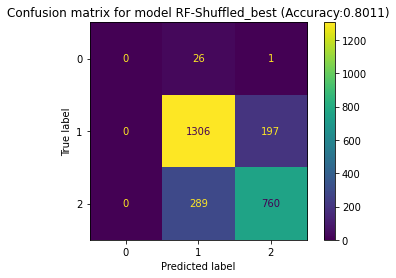

,Accuracy,Weighted F1,Weighted Precision,Weighted Recall,Macro-Averaged Precision,Macro-Averaged Recall,F1,Precision
RF-Shuffled_best,0.801086,0.79532,0.792215,0.801086,0.532998,0.531143,[0. 0.83610755 0.75734928],[0. 0.80567551 0.79331942]


In [16]:
calculate_metrics('RF-Shuffled_best', y_best_predictions, best_predictions)